# Spectral Event Analysis Tutorial

This tutorial is a hands-on introduction to using the [SpectralEvents toolbox](https://github.com/jonescompneurolab/SpectralEvents), **a collection of functions designed to help researchers characterize high-amplitude peaks in the time-frequency representation of continuous neural signals**. Here, we'll load and analyze data that is distributed with the toolbox, as described in [Shin et al. (2017)](https://doi.org/10.7554/eLife.29086).

First, we'll import some dependencies. Note that `seaborn` is not required, but is added to improve plot styling.

In [1]:
%matplotlib inline

import sys
import os.path as op
from glob import glob

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

# import seaborn as sns
# sns.set()

Now let's import the SpectralEvents toolbox module. You might need to modify the path to this module so that your Python interpreter knows where to find it.

In [2]:
# set path to SpectralEvents if necessary
sys.path.append('/gpfs/home/ddiesbur/SpectralEvents')
import spectralevents as se

In [3]:
# dataset parameters
data_dir = op.join(op.dirname(se.__file__), 'data') 
subj_ids = [str(id) for id in range(1, 10 + 1)]  # subject IDs 1-10

n_subjs = len(subj_ids)  # number of subjects
n_trials = 200           # number of trials per subject
n_times = 600            # number of time samples per trial
samp_freq = 600          # sampling rate (Hz)

In [4]:
# load data
hit_trials = list()
data = list()
for id_idx, id in enumerate(subj_ids):
    fname = op.join(data_dir, 'prestim_humandetection_600hzMEG_subject' + id + '.mat')
    raw_data = loadmat(fname)
    hit_trials.append(np.nonzero(raw_data['YorN'].squeeze())[0])  # indices for trials where the stimulus was detected
    data.append(raw_data['prestim_raw_yes_no'])  # MEG time series (trials x samples)

Once you've loaded the data, make sure you understand how it's formatted. There
are 10 subjects, each with 100 detected (i.e., *hit*) trials and 100 undetected (i.e., *miss*) trials. How might you go about selecting only the *hit* trials from the 1st subject?

In [5]:
# investigate data structure: # trials x time for Subj 1
print(data[0].shape)

(200, 600)


## Identifying events in single-subject data
Let's find the spectral events across trial conditions in a single subject,
after which we'll expand the analysis to include all 10 subjects.

In [5]:
subj_data = data[0]

We've loaded the data and must now set the conditions governing Spectral Event detection:
- `freqs`, the frequency values over which you will calculate your **t**ime-**f**requency **r**esponse (TFR)
- `times`, the time values at which your signal was sampled relative to each epoch or trial
- `event_band`, the bounds of the frequency band in which you will look for Spectral Events
- `thresh_FOM`, the factor-of-the-median threshold that will be used to find suprathreshold spectral power in each frequency bin across the spectrogram(s)

The general workflow for event detection follows this progression: **TIMESERIES** -> **TFR** -> **SPECTRAL EVENTS**

In [6]:
# set parameters
freqs = list(range(1, 60 + 1))   # fequency values (Hz) over which to calculate TFR
times = np.arange(n_times) / samp_freq  # seconds
event_band = [15, 29]  # beta band (Hz)
thresh_FOM = 6.0  # factor-of-the-median threshold

**Step 1**: **TIMESERIES** -> **TFR**

In [8]:
# calculate TFR
tfrs = se.tfr(subj_data, freqs, samp_freq)

Let's see what the average spectrogram looks like. (Note that our
band-of-interest, as guided by the literature and discussed in more detail in a
few moments, is the **beta band (15-29 Hz)**.)

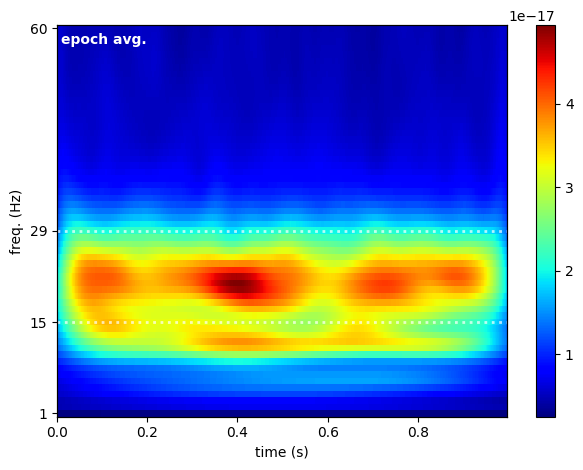

In [13]:
fig = se.plot_avg_spectrogram(tfr=tfrs, times=times, freqs=freqs,
                              event_band=event_band)

What if we separate between the two experimental conditions, *hit* versus
*miss* trials? We can do this by plotting the average spectrogram for each set
of trials separately but setting the spectrogram scaling the same.

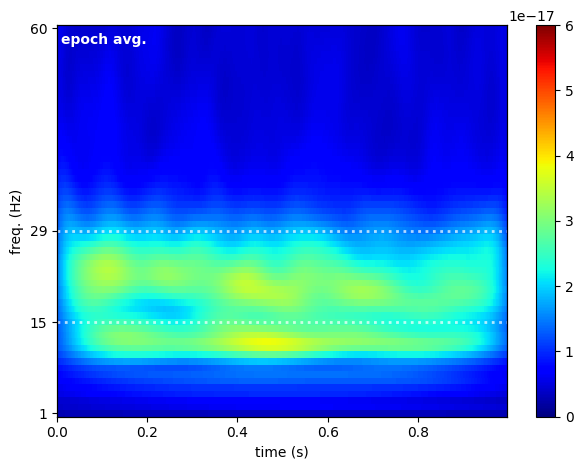

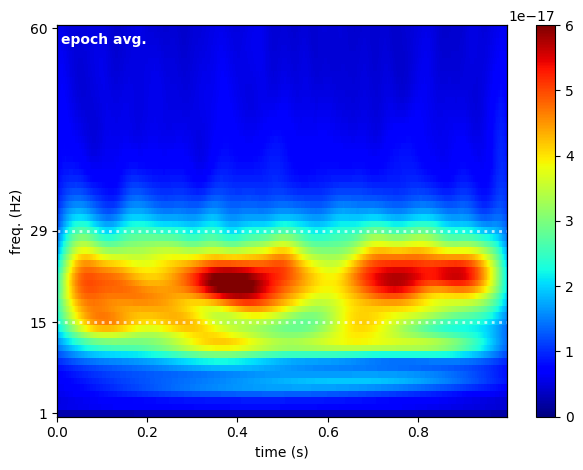

In [13]:
subj_hit_trials = hit_trials[0]
subj_miss_trials = [idx for idx in range(n_trials) if idx not in subj_hit_trials]
vlim = [0, 6.0e-17]

fig = se.plot_avg_spectrogram(tfr=tfrs[subj_hit_trials],
                              times=times,
                              freqs=freqs,
                              event_band=event_band,
                              vlim=vlim)  # note the vlim argument!

fig = se.plot_avg_spectrogram(tfr=tfrs[subj_miss_trials],
                              times=times,
                              freqs=freqs,
                              event_band=event_band,
                              vlim=vlim)  # note the vlim argument!

A few observations:

1. It appears that there is **beta** activity across time and trials.

2. This activity is more pronounced in *miss* trials specficially.

If the high beta power is indeed driven by a beta *rhythm*, we should be
able to observe it in individual trials. Let's see what a few individual
trials look like. We will use `plot_avg_spectrogram()` as before, but this time
specify individual trials via the argument `example_epochs`. This will allow us
to see how spectrograms from specific trials combine to produce a single
average spectrogram.

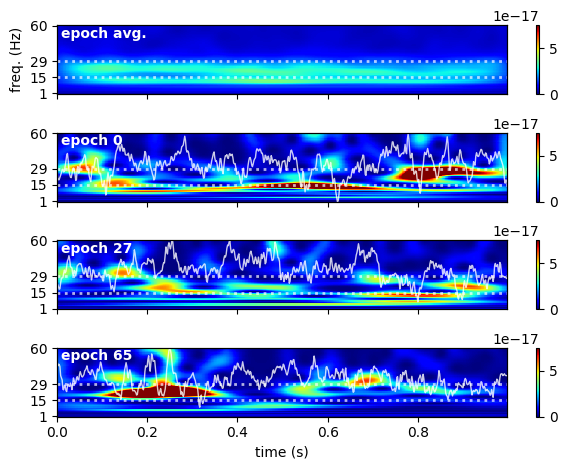

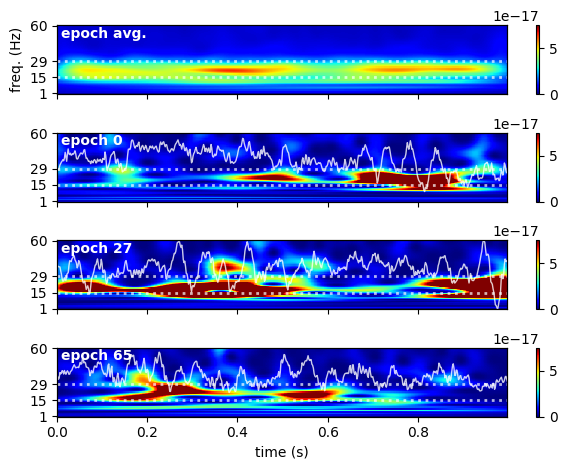

In [14]:
example_trials = [0, 27, 65]
vlim = [0, 7.5e-17]

fig = se.plot_avg_spectrogram(tfr=tfrs[subj_hit_trials],
                              times=times,
                              freqs=freqs,
                              event_band=event_band,
                              timeseries=subj_data[subj_hit_trials],
                              example_epochs=example_trials,  # note the example_epochs argument!
                              vlim=vlim)

fig = se.plot_avg_spectrogram(tfr=tfrs[subj_miss_trials],
                              times=times,
                              freqs=freqs,
                              event_band=event_band,
                              timeseries=subj_data[subj_miss_trials],
                              example_epochs=example_trials,  # note the example_epochs argument!
                              vlim=vlim)

Interestingly, a constant beta *rhythm* is not present in many of these trials.
Instead, there appears to be a handful of transient, non-time-locked *events* of
beta activity.

**Step 2**: **TFR** -> **SPECTRAL EVENTS**

Now we can see if the observed bursts in beta activity equate to detectable
spectral events across all trials.

Find with Method 1 (same as previously demonstrated in tutorial)

In [16]:
# find spectral events!!
spec_events_meth1 = se.find_events(tfr=tfrs, times=times, freqs=freqs,
                             event_band=event_band, thresholds=None, threshold_FOM=thresh_FOM, find_method=1)

`spec_events` is is a nested list (trials x events). Each event is annotated by
dictionary key-value pairs that include `Peak Time`, `Peak Frequency`,
`Peak Power`, `Duration`, `Frequency Span`, amoung a few others.

In [17]:
print(len(spec_events_meth1))  # number of trials
print(len(spec_events_meth1[0]))  # number of events in the 1st trial
spec_events_meth1[0][0]  # features of the 1st event of the 1st trial

200
1


{'Peak Frequency': 25,
 'Lower Frequency Bound': 20,
 'Upper Frequency Bound': 30,
 'Frequency Span': 10,
 'Peak Time': 0.82,
 'Event Onset Time': 0.7733333333333333,
 'Event Offset Time': 0.9,
 'Event Duration': 0.1266666692,
 'Peak Power': 1.6775259732823184e-16,
 'Normalized Peak Power': 10.087765786470598}

Find with Method 3, newly added!

In [18]:
# find spectral events!!
spec_events_meth3 = se.find_events(tfr=tfrs, times=times, freqs=freqs,
                             event_band=event_band, thresholds=None, threshold_FOM=6., find_method=3)

In [19]:
print(len(spec_events_meth3))  # number of trials
print(len(spec_events_meth3[0]))  # number of events in the 1st trial
spec_events_meth3[0][0]  # features of the 1st event of the 1st trial

200
1


{'Peak Frequency': 27,
 'Lower Frequency Bound': 22,
 'Upper Frequency Bound': 31,
 'Frequency Span': 9,
 'Peak Time': 0.83,
 'Event Onset Time': 0.7783333333333333,
 'Event Offset Time': 0.9116666666666666,
 'Event Duration': 0.133333336,
 'Peak Power': 10.768111867044297,
 'Normalized Peak Power': 7.59213982516339e+17}

Now we can overlay the same spectrograms with the **beta events**. Note that the results from Method 3, which attempts to avoid overlapping events, contains fewer identified events, particularly in epoch 27 of miss trials.

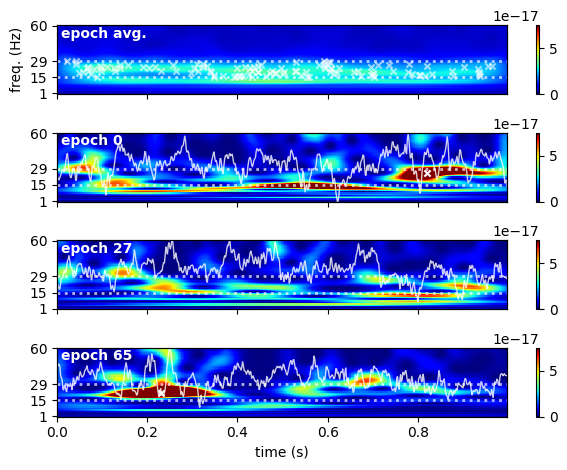

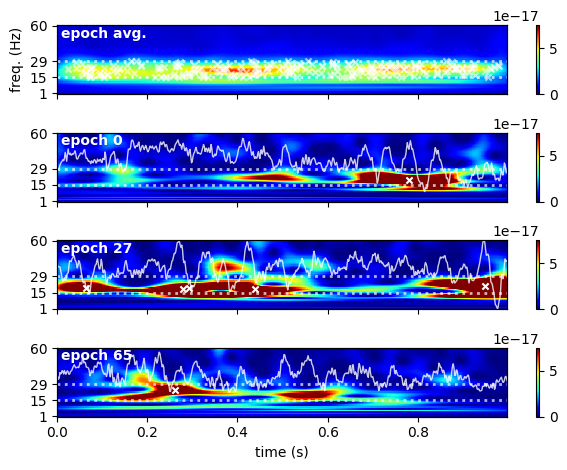

In [20]:
# Method 1 results
hit_spec_events = [trial_events for trial_idx, trial_events in enumerate(spec_events_meth1)
                   if trial_idx in subj_hit_trials]
miss_spec_events = [trial_events for trial_idx, trial_events in enumerate(spec_events_meth1)
                    if trial_idx in subj_miss_trials]

fig = se.plot_avg_spectrogram(tfr=tfrs[subj_hit_trials],
                              times=times,
                              freqs=freqs,
                              event_band=event_band,
                              spec_events=hit_spec_events,  # note the spec_events argument!
                              timeseries=subj_data[subj_hit_trials],
                              example_epochs=example_trials,
                              show_events=True,  # note the show_events argument!
                              vlim=vlim)

fig = se.plot_avg_spectrogram(tfr=tfrs[subj_miss_trials],
                              times=times,
                              freqs=freqs,
                              event_band=event_band,
                              spec_events=miss_spec_events, # note the spec_events argument!
                              timeseries=subj_data[subj_miss_trials],
                              example_epochs=example_trials,
                              show_events=True,  # note the show_events argument!
                              vlim=vlim)

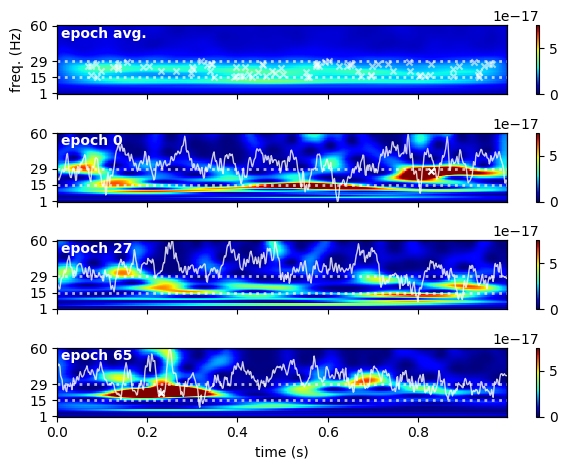

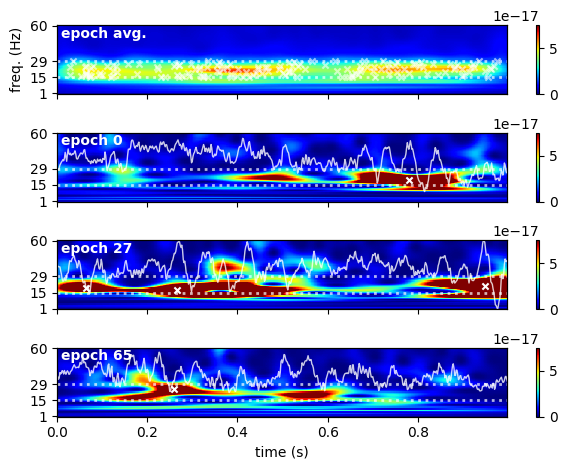

In [21]:
# Method 3 results
hit_spec_events = [trial_events for trial_idx, trial_events in enumerate(spec_events_meth3)
                   if trial_idx in subj_hit_trials]
miss_spec_events = [trial_events for trial_idx, trial_events in enumerate(spec_events_meth3)
                    if trial_idx in subj_miss_trials]

fig = se.plot_avg_spectrogram(tfr=tfrs[subj_hit_trials],
                              times=times,
                              freqs=freqs,
                              event_band=event_band,
                              spec_events=hit_spec_events,  # note the spec_events argument!
                              timeseries=subj_data[subj_hit_trials],
                              example_epochs=example_trials,
                              show_events=True,  # note the show_events argument!
                              vlim=vlim)

fig = se.plot_avg_spectrogram(tfr=tfrs[subj_miss_trials],
                              times=times,
                              freqs=freqs,
                              event_band=event_band,
                              spec_events=miss_spec_events, # note the spec_events argument!
                              timeseries=subj_data[subj_miss_trials],
                              example_epochs=example_trials,
                              show_events=True,  # note the show_events argument!
                              vlim=vlim)

Indeed, it appears that single trial spectrograms might contain
non-time-locked beta events. Importantly, the *miss* trials appear to have more
of them. To investigate this further we can plot the distribution of spectral
events per trial.

Text(0, 0.5, 'number of trials')

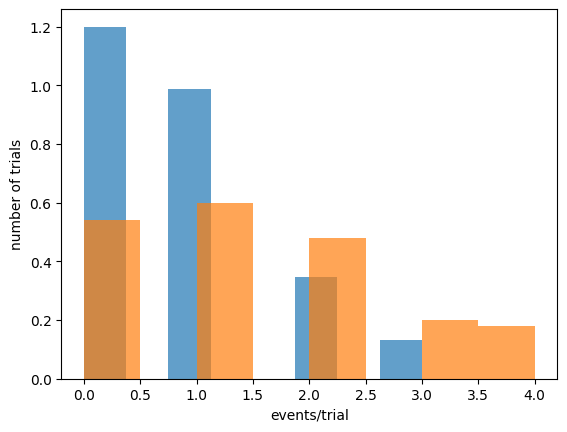

In [22]:
hit_event_counts = [len(events) for events in hit_spec_events]
miss_event_counts = [len(events) for events in miss_spec_events]

plt.figure()
plt.hist(hit_event_counts, label='hit', bins=8, density=True, alpha=0.7)
plt.hist(miss_event_counts, label='miss', bins=8, density=True, alpha=0.7)
plt.xlabel('events/trial')
plt.ylabel('number of trials')

A few things to consider:

1. What does this tell you about the trial-average spectrogram?

2. Is this trend conserved across subjects?

Before we move on, let's create a function for extracting the trial-average
difference between the spectral event count in *hit* versus *miss* trials.

In [23]:
def avg_event_count_diff(subj_spec_events, subj_hit_trials):

    # initialize the event count to 0
    hit_event_count = 0
    miss_event_count = 0

    # iterate over trials and add event counts depending on trial type
    for trial_idx, trial_events in enumerate(subj_spec_events):
        if trial_idx in subj_hit_trials:
            hit_event_count += len(trial_events)
        else:
            miss_event_count += len(trial_events)

    return (hit_event_count - miss_event_count) / len(subj_hit_trials)

## Identifying events in multiple subjects
Now let's exand our beta event detection to include data from all 10 subjects.
To do this, we'll create one big loop that iterates over our
**TIMESERIES** -> **TFR** -> **SPECTRAL EVENTS** workflow for each subject.

In [24]:
# calculate time-frequency response (TFR)
all_tfrs = np.zeros((n_subjs, n_trials, len(freqs), n_times))
all_spec_events = list()
all_hit_miss_count_diff = list()

for subj_idx, subj_data in enumerate(data):

    # calculate TFRs
    tfrs = se.tfr(subj_data, freqs, samp_freq)

    # find events
    spec_events = se.find_events(tfr=tfrs, times=times, freqs=freqs,
                                 event_band=event_band, threshold_FOM=6., find_method=1)

    # find the average event count difference for this subject
    subj_hit_trials = hit_trials[subj_idx]
    hit_miss_count_diff = avg_event_count_diff(spec_events, subj_hit_trials)
    all_hit_miss_count_diff.append(hit_miss_count_diff)

    # store TFRs and events for later
    all_tfrs[subj_idx, :, :, :] = tfrs
    all_spec_events.append(spec_events)

To test whether beta events are more likely to occur in *miss* trials compared
to *hit* trials across subjects, we can plot the trial-average difference in
the number of detected events for *hit* minus *miss* trials. While a formal
statistical test would require more subjects, this hopefully builds intuition
for how spectral event features can be used to test hypotheses about
differences in spectral events between experimental conditions.

Text(0.5, 0, 'difference in # of events')

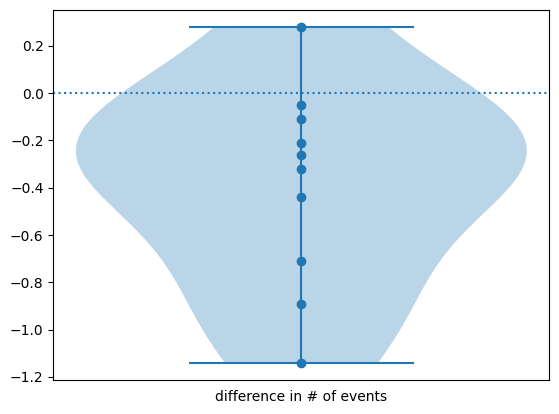

In [25]:
plt.figure()
plt.violinplot(all_hit_miss_count_diff)
plt.scatter(np.ones((n_subjs,)), all_hit_miss_count_diff)
plt.xticks([])
plt.axhline(0, linestyle=':')
plt.xlabel('difference in # of events')

Other commonly used spectral event features include

- `Peak Power`, an event's power maximum
- `Duration`, an event's width in time
- `Frequency Span`, an event's width in frequency space

These features are left for you to explore further!